# 잘 안되는 버전

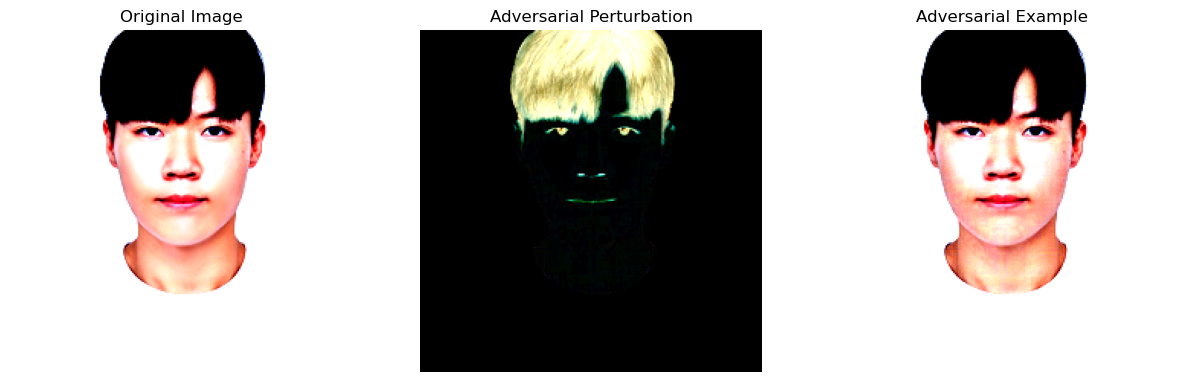

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
from PIL import Image
import clip
import matplotlib.pyplot as plt

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Load and preprocess image
image_path = 'yeongmin.jpeg'  # Replace with your image path
image_pil = Image.open(image_path).convert('RGB')
image_tensor = preprocess(image_pil).unsqueeze(0).to(device)

# Target text token (to maximize similarity with adversarial noise)
target_text = "a distorted image"
target_text_token = clip.tokenize([target_text]).to(device)

def generate_adversarial_noise(image_tensor, model, target_text_token, epsilon=0.1, steps=10):
    image_tensor = image_tensor.clone().detach().requires_grad_(True).to(device)
    target_text_token = target_text_token.to(device)
    
    optimizer = optim.Adam([image_tensor], lr=epsilon)

    for step in range(steps):
        optimizer.zero_grad()

        # Normalize the image tensor
        normalized_image = (image_tensor - image_tensor.min()) / (image_tensor.max() - image_tensor.min())
        
        # Forward pass
        image_features = model.encode_image(normalized_image)
        text_features = model.encode_text(target_text_token)
        
        # Compute loss (maximize similarity)
        similarity = (image_features @ text_features.T).squeeze(0)
        loss = -similarity.mean()

        # Backward pass
        loss.backward()
        optimizer.step()

        # Clamp the perturbation to the epsilon level
        perturbation = torch.clamp(image_tensor - image_tensor.detach(), -epsilon, epsilon)
        image_tensor = torch.clamp(image_tensor + perturbation, 0, 1).detach().requires_grad_(True)

    return image_tensor

def tensor_to_image(tensor):
    # Convert tensor to PIL image, ensuring the original is preserved
    image_np = tensor.cpu().detach().numpy().transpose(1, 2, 0)
    image_np = np.clip(image_np * 255, 0, 255).astype(np.uint8)
    return image_np

# Generate adversarial noise
adversarial_image_tensor = generate_adversarial_noise(image_tensor, model, target_text_token, epsilon=0.03, steps=10)

# Convert images for display
original_image_np = tensor_to_image(image_tensor.squeeze(0))
adversarial_image_np = tensor_to_image(adversarial_image_tensor.squeeze(0))
perturbation_np = tensor_to_image(adversarial_image_tensor.squeeze(0) - image_tensor.squeeze(0))

# Plot the original, adversarial, and difference images side by side
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_image_np)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Adversarial Perturbation")
plt.imshow(perturbation_np)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Adversarial Example")
plt.imshow(adversarial_image_np)
plt.axis('off')

plt.show()

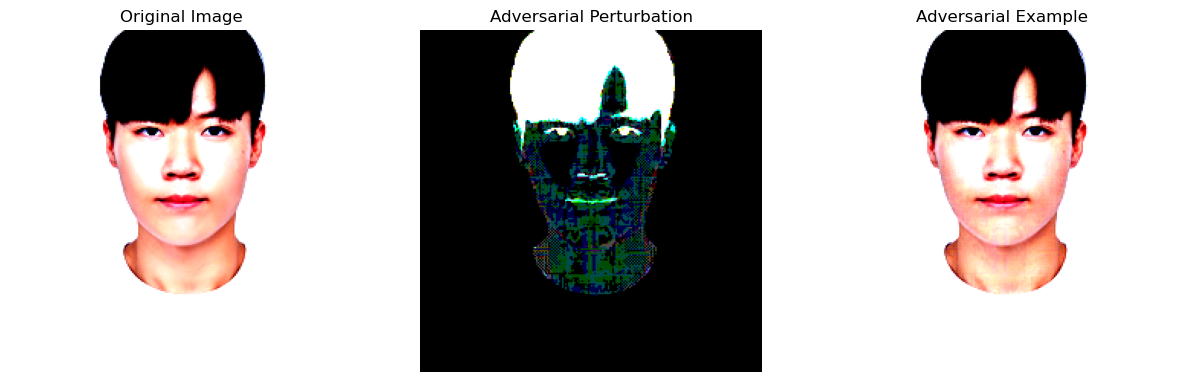

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
from PIL import Image
import clip
import matplotlib.pyplot as plt

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Load and preprocess image
image_path = 'yeongmin.jpeg'  # Replace with your image path
image_pil = Image.open(image_path).convert('RGB')
image_tensor = preprocess(image_pil).unsqueeze(0).to(device)

# Target text token (to maximize similarity with adversarial noise)
target_text = "a distorted image"
target_text_token = clip.tokenize([target_text]).to(device)

def generate_adversarial_noise(image_tensor, model, target_text_token, epsilon=0.1, steps=10):
    image_tensor = image_tensor.clone().detach().requires_grad_(True).to(device)
    target_text_token = target_text_token.to(device)
    
    optimizer = optim.Adam([image_tensor], lr=epsilon)

    for step in range(steps):
        optimizer.zero_grad()

        # Normalize the image tensor
        normalized_image = (image_tensor - image_tensor.min()) / (image_tensor.max() - image_tensor.min())
        
        # Forward pass
        image_features = model.encode_image(normalized_image)
        text_features = model.encode_text(target_text_token)
        
        # Compute loss (maximize similarity)
        similarity = (image_features @ text_features.T).squeeze(0)
        loss = -similarity.mean()

        # Backward pass
        loss.backward()
        optimizer.step()

        # Clamp the perturbation to the epsilon level
        perturbation = torch.clamp(image_tensor - image_tensor.detach(), -epsilon, epsilon)
        image_tensor = torch.clamp(image_tensor + perturbation, 0, 1).detach().requires_grad_(True)

    return image_tensor

def tensor_to_image(tensor):
    # Remove batch dimension and convert tensor to NumPy array
    tensor = tensor.squeeze(0)
    image_np = tensor.cpu().detach().numpy().transpose(1, 2, 0)
    
    # Convert the image from RGB to BGR format for OpenCV saving
    image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    
    # Ensure values are in the range [0, 1] before scaling
    image_np = np.clip(image_np, 0, 1)
    
    # Convert from [0, 1] range to [0, 255] range for image saving
    image_np = (image_np * 255).astype(np.uint8)
    
    return image_np

# Generate adversarial noise
adversarial_image_tensor = generate_adversarial_noise(image_tensor, model, target_text_token, epsilon=0.03, steps=10)

# Convert tensors to images with proper color handling
original_image_np = tensor_to_image(image_tensor)
adversarial_image_np = tensor_to_image(adversarial_image_tensor)
perturbation_np = tensor_to_image((adversarial_image_tensor - image_tensor) * 10)  # Amplify perturbation for visibility

# Save the images with corrected color handling
cv2.imwrite('original_image_fixed.jpg', original_image_np)
cv2.imwrite('adversarial_image_fixed.jpg', adversarial_image_np)
cv2.imwrite('perturbation_image_fixed.jpg', perturbation_np)

# Plot the original, adversarial, and perturbation images side by side
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(original_image_np, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Adversarial Perturbation")
plt.imshow(cv2.cvtColor(perturbation_np, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Adversarial Example")
plt.imshow(cv2.cvtColor(a

In [48]:
import torch
import clip
from PIL import Image
import cv2
import numpy as np

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Define the text descriptions you want to classify with
texts = ["a photo of a person", "a distorted image", "blurred eyes", "blurred nose", "blurred mouth"]
text_tokens = clip.tokenize(texts).to(device)

# Load and preprocess the images
def load_and_preprocess_image(image_path):
    image_pil = Image.open(image_path).convert('RGB')
    image_tensor = preprocess(image_pil).unsqueeze(0).to(device)
    return image_tensor

# Paths to the saved images
original_image_path = 'original_image_fixed.jpg'
adversarial_image_path = 'adversarial_image_fixed.jpg'
perturbation_image_path = 'perturbation_image_fixed.jpg'

# Load the images
original_image_tensor = load_and_preprocess_image(original_image_path)
adversarial_image_tensor = load_and_preprocess_image(adversarial_image_path)
perturbation_image_tensor = load_and_preprocess_image(perturbation_image_path)

# Function to classify the images
def classify_image(image_tensor, model, text_tokens):
    with torch.no_grad():
        image_features = model.encode_image(image_tensor)
        text_features = model.encode_text(text_tokens)
    
    # Calculate similarity between image and each text description
    similarities = (image_features @ text_features.T).squeeze(0)
    
    # Normalize similarities to get probabilities (optional)
    probs = similarities.softmax(dim=-1).cpu().numpy()
    
    return probs

# Classify the images
original_probs = classify_image(original_image_tensor, model, text_tokens)
adversarial_probs = classify_image(adversarial_image_tensor, model, text_tokens)
perturbation_probs = classify_image(perturbation_image_tensor, model, text_tokens)

# Print the results
def print_classification_results(probs, image_name):
    print(f"Classification probabilities for {image_name}:")
    for i, prob in enumerate(probs):
        print(f"{texts[i]}: {prob * 100:.2f}%")
    print()

print_classification_results(original_probs, "Original Image")
print_classification_results(adversarial_probs, "Adversarial Image")
print_classification_results(perturbation_probs, "Perturbation Image")

Classification probabilities for Original Image:
a photo of a person: 77.98%
a distorted image: 21.98%
blurred eyes: 0.03%
blurred nose: 0.02%
blurred mouth: 0.00%

Classification probabilities for Adversarial Image:
a photo of a person: 92.63%
a distorted image: 7.37%
blurred eyes: 0.00%
blurred nose: 0.00%
blurred mouth: 0.00%

Classification probabilities for Perturbation Image:
a photo of a person: 3.02%
a distorted image: 96.97%
blurred eyes: 0.01%
blurred nose: 0.00%
blurred mouth: 0.00%



# 잘된 버전

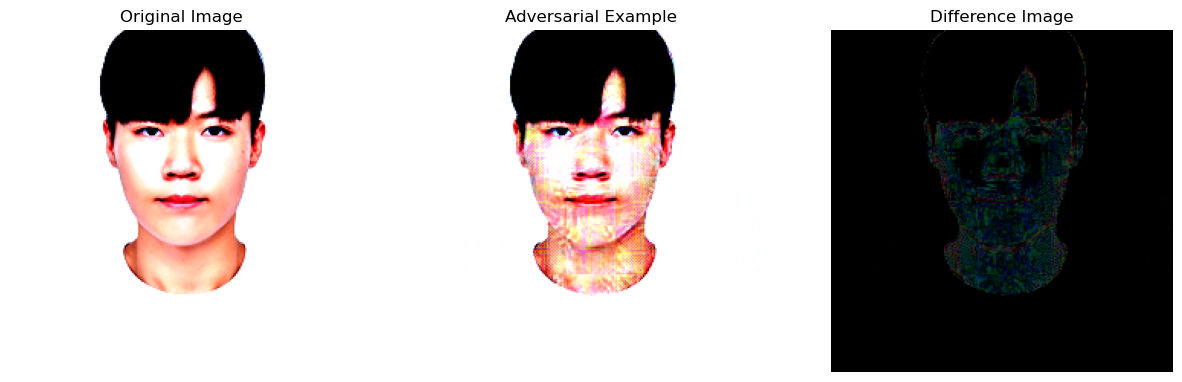

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
from PIL import Image
import clip
import matplotlib.pyplot as plt

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Load and preprocess image (preserve original size)
image_path = 'yeongmin.jpeg'  # Replace with your image path
original_image = Image.open(image_path).convert('RGB')
image_tensor = preprocess(original_image).unsqueeze(0).to(device)

# Target text token (to maximize similarity with adversarial noise)
target_text = "a distorted image"
target_text_token = clip.tokenize([target_text]).to(device)

def generate_adversarial_noise(image_tensor, model, target_text_token, epsilon=0.03, steps=10):
    image_tensor = image_tensor.clone().detach().requires_grad_(True).to(device)
    target_text_token = target_text_token.to(device)
    
    optimizer = optim.Adam([image_tensor], lr=epsilon)

    for step in range(steps):
        optimizer.zero_grad()

        # Forward pass
        normalized_image = (image_tensor - image_tensor.min()) / (image_tensor.max() - image_tensor.min())
        image_features = model.encode_image(normalized_image)
        text_features = model.encode_text(target_text_token)
        
        # Compute loss (maximize similarity)
        similarity = (image_features @ text_features.T).squeeze(0)
        loss = -similarity.mean()

        # Backward pass
        loss.backward()
        optimizer.step()

        # Apply perturbation with minimal noise
        perturbation = torch.clamp(image_tensor - image_tensor.detach(), -epsilon, epsilon)
        adversarial_image = torch.clamp(image_tensor + perturbation, 0, 1).detach()

    return adversarial_image

def tensor_to_image(tensor, original_size):
    # Convert tensor to NumPy image array
    tensor = tensor.squeeze(0).cpu().detach().numpy().transpose(1, 2, 0)
    
    # Ensure values are in the correct range [0, 1]
    tensor_resized = np.clip(tensor, 0, 1)
    
    # Convert to BGR for saving with OpenCV
    tensor_resized = cv2.cvtColor(tensor_resized, cv2.COLOR_RGB2BGR)
    
    # Convert from [0, 1] to [0, 255] range
    tensor_resized = (tensor_resized * 255).astype(np.uint8)
    
    return tensor_resized

# Generate adversarial noise
adversarial_image_tensor = generate_adversarial_noise(image_tensor, model, target_text_token, epsilon=0.03, steps=10)

# Get original image size
original_size = original_image.size

# Convert tensors to images
original_image_np = tensor_to_image(image_tensor, original_size)
adversarial_image_np = tensor_to_image(adversarial_image_tensor, original_size)

# Calculate difference image
diff_image_np = cv2.absdiff(original_image_np, adversarial_image_np)

# Save the images
cv2.imwrite('original_image_fixed.jpg', original_image_np)
cv2.imwrite('adversarial_image_fixed.jpg', adversarial_image_np)
cv2.imwrite('diff_image_fixed.jpg', diff_image_np)

# Plot the original, adversarial, and difference images side by side
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(original_image_np, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Adversarial Example")
plt.imshow(cv2.cvtColor(adversarial_image_np, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Difference Image")
plt.imshow(cv2.cvtColor(diff_image_np, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

In [58]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

texts = ["a photo of a person", "blurred eyes", "blurred nose", "blurred mouth", "distorted image", "noisy image", "colorful image",
  'apple', 
  'aquarium_fish',
  'baby',
  'bear',
  'beaver',
  'bed',
  'bee',
  'beetle',
  'bicycle',
  'bottle',
  'bowl',
  'boy',
  'bridge',
  'bus',
  'butterfly',
  'camel',
  'can',
  'castle',
  'caterpillar',
  'cattle',
  'chair',
  'chimpanzee',
  'clock',
  'cloud',
  'cockroach',
  'couch',
  'crab',
  'crocodile',
  'cup',
  'dinosaur',
  'dolphin',
  'elephant',
  'flatfish',
  'forest',
  'fox',
  'girl',
  'hamster',
  'house',
  'kangaroo',
  'computer_keyboard',
  'lamp',
  'lawn_mower',
  'leopard',
  'lion',
  'lizard',
  'lobster',
  'man',
  'maple_tree',
  'motorcycle',
  'mountain',
  'mouse',
  'mushroom',
  'oak_tree',
  'orange',
  'orchid',
  'otter',
  'palm_tree',
  'pear',
  'pickup_truck',
  'pine_tree',
  'plain',
  'plate',
  'poppy',
  'porcupine',
  'possum',
  'rabbit',
  'raccoon',
  'ray',
  'road',
  'rocket',
  'rose',
  'sea',
  'seal',
  'shark',
  'shrew',
  'skunk',
  'skyscraper',
  'snail',
  'snake',
  'spider',
  'squirrel',
  'streetcar',
  'sunflower',
  'sweet_pepper',
  'table',
  'tank',
  'telephone',
  'television',
  'tiger',
  'tractor',
  'train',
  'trout',
  'tulip',
  'turtle',
  'wardrobe',
  'whale',
  'willow_tree',
  'wolf',
  'woman',
  'worm',]
text_tokens = clip.tokenize(texts).to(device)

def load_and_preprocess_image(image_path):
    image_pil = Image.open(image_path).convert('RGB')
    image_tensor = preprocess(image_pil).unsqueeze(0).to(device)
    return image_tensor

original_image_path = 'original_image_fixed.jpg'
adversarial_image_path = 'adversarial_image_fixed.jpg'
perturbation_image_path = 'perturbation_image_fixed.jpg'

original_image_tensor = load_and_preprocess_image(original_image_path)
adversarial_image_tensor = load_and_preprocess_image(adversarial_image_path)
perturbation_image_tensor = load_and_preprocess_image(perturbation_image_path)

def classify_image(image_tensor, model, text_tokens):
    with torch.no_grad():
        image_features = model.encode_image(image_tensor)
        text_features = model.encode_text(text_tokens)

    similarities = (image_features @ text_features.T).squeeze(0)

    probs = similarities.softmax(dim=-1).cpu().numpy()
    
    return probs

original_probs = classify_image(original_image_tensor, model, text_tokens)
adversarial_probs = classify_image(adversarial_image_tensor, model, text_tokens)
perturbation_probs = classify_image(perturbation_image_tensor, model, text_tokens)

def print_classification_results(probs, image_name):
    print(f"Classification probabilities for {image_name}:")
    for i, prob in enumerate(probs):
        print(f"{texts[i]}: {prob * 100:.2f}%")
    print()

print_classification_results(original_probs, "Original Image")
print_classification_results(adversarial_probs, "Adversarial Image")
print_classification_results(perturbation_probs, "Perturbation Image")

Classification probabilities for Original Image:
a photo of a person: 54.00%
blurred eyes: 0.02%
blurred nose: 0.01%
blurred mouth: 0.00%
distorted image: 2.53%
noisy image: 4.30%
colorful image: 0.13%
apple: 0.02%
aquarium_fish: 0.00%
baby: 1.37%
bear: 0.02%
beaver: 0.00%
bed: 0.00%
bee: 0.00%
beetle: 0.00%
bicycle: 0.00%
bottle: 0.00%
bowl: 0.01%
boy: 4.87%
bridge: 0.00%
bus: 0.01%
butterfly: 0.00%
camel: 0.00%
can: 9.24%
castle: 0.00%
caterpillar: 0.00%
cattle: 0.00%
chair: 0.00%
chimpanzee: 0.00%
clock: 0.01%
cloud: 0.00%
cockroach: 0.00%
couch: 0.00%
crab: 0.00%
crocodile: 0.00%
cup: 0.01%
dinosaur: 0.00%
dolphin: 0.00%
elephant: 0.00%
flatfish: 0.00%
forest: 0.00%
fox: 0.00%
girl: 1.14%
hamster: 0.00%
house: 0.01%
kangaroo: 0.00%
computer_keyboard: 0.01%
lamp: 0.00%
lawn_mower: 0.00%
leopard: 0.00%
lion: 0.00%
lizard: 0.00%
lobster: 0.00%
man: 20.51%
maple_tree: 0.00%
motorcycle: 0.00%
mountain: 0.01%
mouse: 0.02%
mushroom: 0.03%
oak_tree: 0.00%
orange: 0.00%
orchid: 0.00%
otter: